In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
col_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [3]:
df=pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv')
df=df.set_index('Datetime')
df.index=pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


<AxesSubplot:title={'center':'PJME Energy use in MW'}, xlabel='Datetime'>

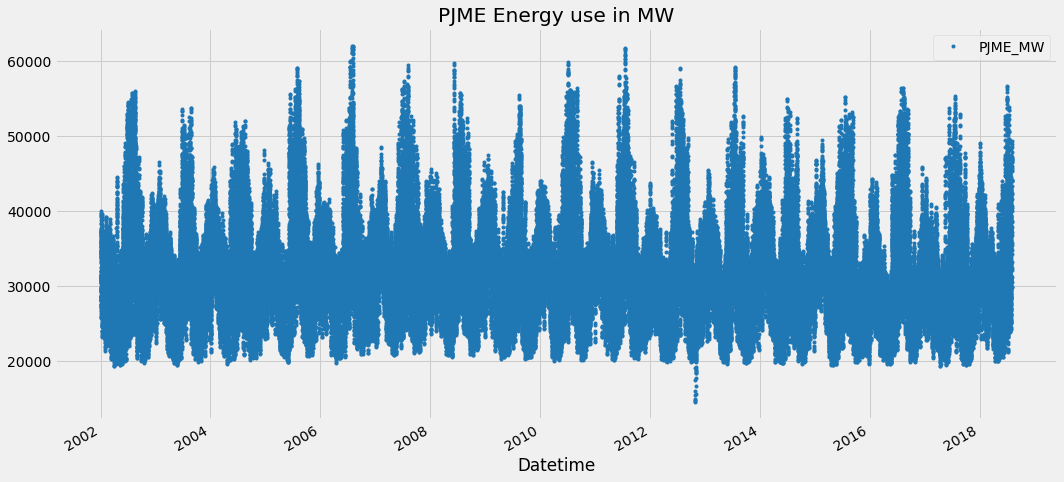

In [5]:
df.plot(style='.',figsize=(16,8),color=col_pal[0],title='PJME Energy use in MW')

# splitting the data into train and test

* train data= from begining to 2015
* test data= from 2015 to ending

In [6]:
train = df.loc[df.index<'01-01-2015']
test = df.loc[df.index>='01-01-2015']

# visualizing train and test data

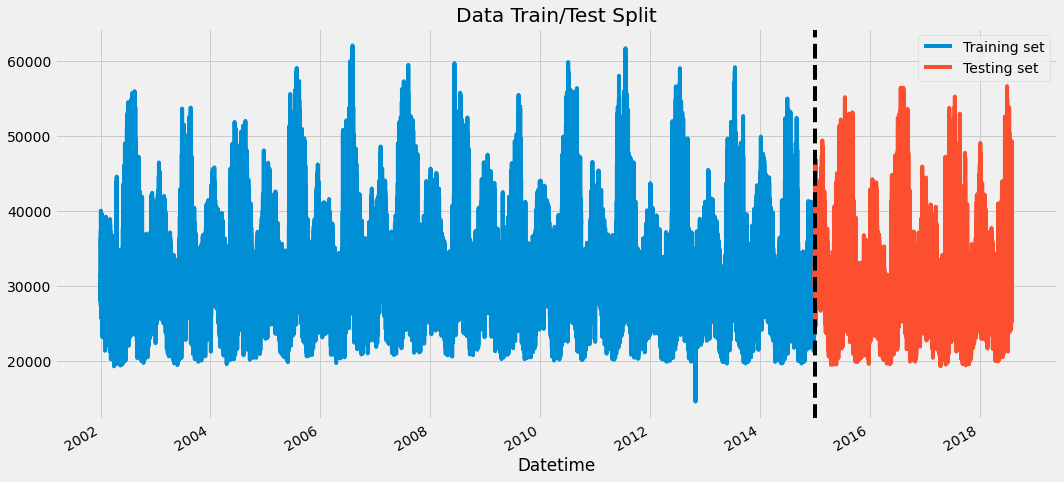

In [7]:
fig,ax=plt.subplots(figsize=(16,8))
train.plot(ax=ax,label='Training set',title='Data Train/Test Split')
test.plot(ax=ax,label='Testing set')
ax.axvline('01-01-2015',color='k',ls='--')
ax.legend(['Training set','Testing set'])
plt.show()

# visualizing a single week

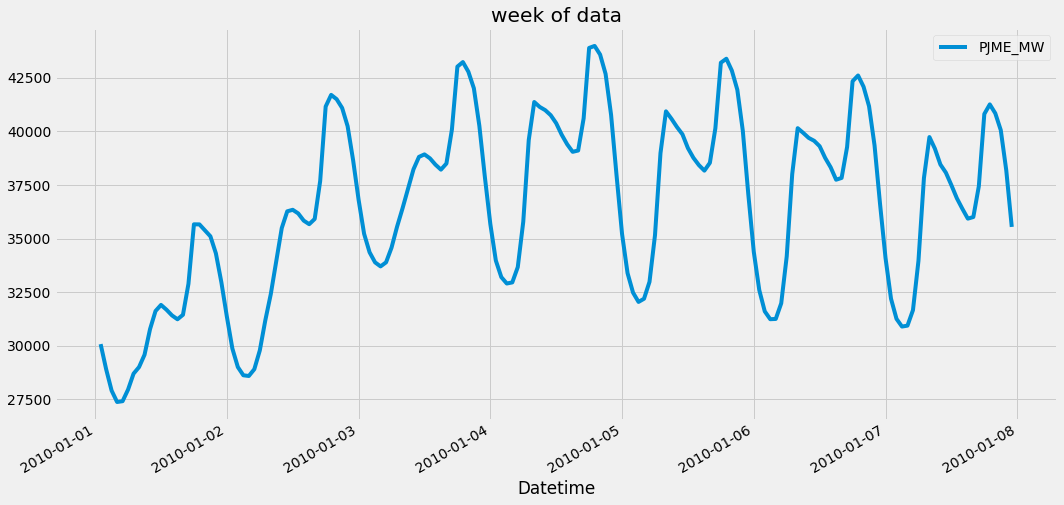

In [8]:
df.loc[(df.index>'01-01-2010') & (df.index<'01-08-2010')].plot(figsize=(16,8),title='week of data')
plt.show()

there are 2 defferent peak in daily consumption. high peak in day and low peak in night and that is very common in energy consumption.
and the first day in january had very low consumption so it seems to be a holiday(weekend).

# Feature Creation

In [9]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df
df = create_features(df)

# Visualize Feature/Target Relationship

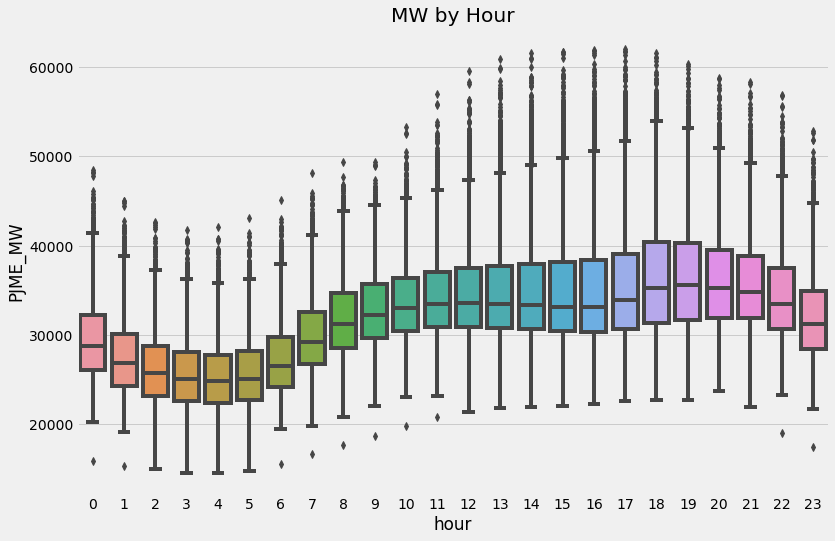

In [10]:
fig,ax=plt.subplots(figsize=(12,8))
sns.boxplot(data=df,x='hour',y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

we see that the median of maximum consumption in 19 hour clock and the menimum in 4 hour clock.

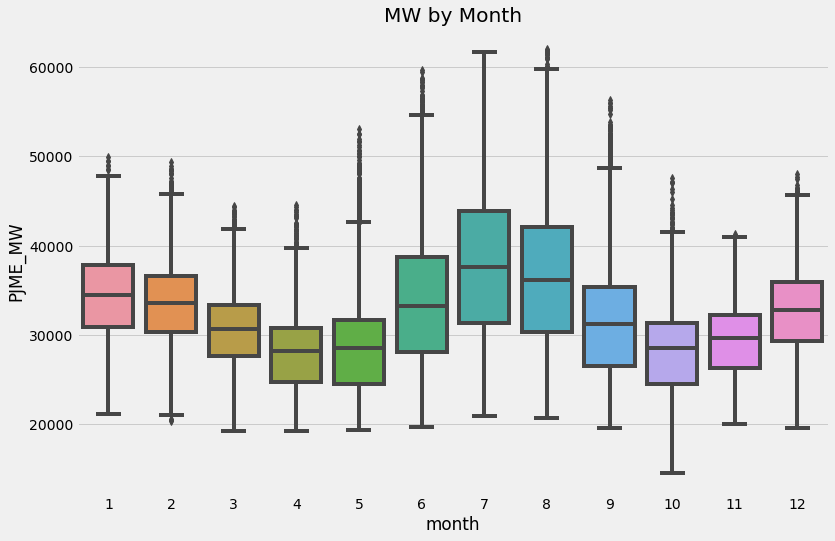

In [11]:
fig,ax=plt.subplots(figsize=(12,8))
sns.boxplot(data=df,x='month',y='PJME_MW')
ax.set_title('MW by Month')
plt.show()

 the median of maximum consumption in july and the menimum in april.

# Create Model

In [12]:
train=create_features(train)
test=create_features(test)

In [13]:
Features=['hour','dayofweek','quarter','month','year','dayofyear']
Target='PJME_MW'

In [14]:
x_train=train[Features]
y_train=train[Target]
x_test=test[Features]
y_test=test[Target]

In [15]:
reg=xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,learning_rate=.01)
reg.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],verbose=100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.13873	validation_1-rmse:11517.66004
[200]	validation_0-rmse:5373.33346	validation_1-rmse:5165.30811
[300]	validation_0-rmse:3375.20923	validation_1-rmse:3829.25476
[400]	validation_0-rmse:2882.55200	validation_1-rmse:3715.04915
[437]	validation_0-rmse:2793.31200	validation_1-rmse:3727.16078


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=50, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

# Feature Importance

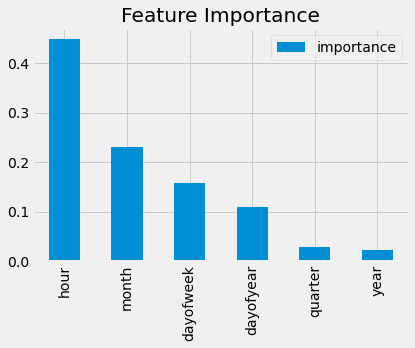

In [16]:
FI=pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
FI.sort_values('importance',ascending=False).plot(kind='bar',title='Feature Importance')
plt.show()

# Forecasting on Test data

In [17]:
test['prediction']=reg.predict(x_test)

In [18]:
df=df.merge(test[['prediction']],how='left',left_index=True,right_index=True)
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN


In [19]:
df.tail(10)

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2018-08-02 15:00:00,47154.0,15,3,3,8,2018,214,2,31,41849.429688
2018-08-02 16:00:00,46989.0,16,3,3,8,2018,214,2,31,41965.621094
2018-08-02 17:00:00,46816.0,17,3,3,8,2018,214,2,31,42243.117188
2018-08-02 18:00:00,46760.0,18,3,3,8,2018,214,2,31,42243.117188
2018-08-02 19:00:00,45641.0,19,3,3,8,2018,214,2,31,41930.781250
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,41014.218750
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,40507.140625
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,38933.621094
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,35820.210938


# visualizing real and forecasting data

<function matplotlib.pyplot.show(close=None, block=None)>

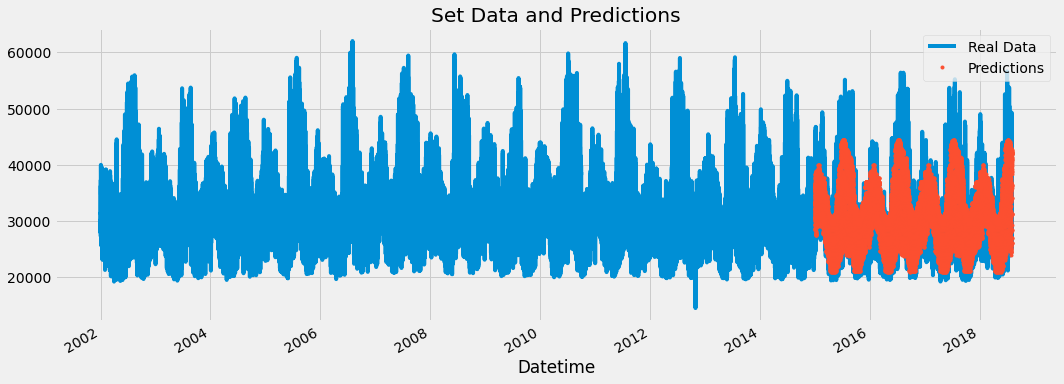

In [20]:
ax=df[['PJME_MW']].plot(figsize=(16,6))
df['prediction'].plot(ax=ax,style='.')
plt.legend(['Real Data','Predictions'])
ax.set_title('Set Data and Predictions')
plt.show

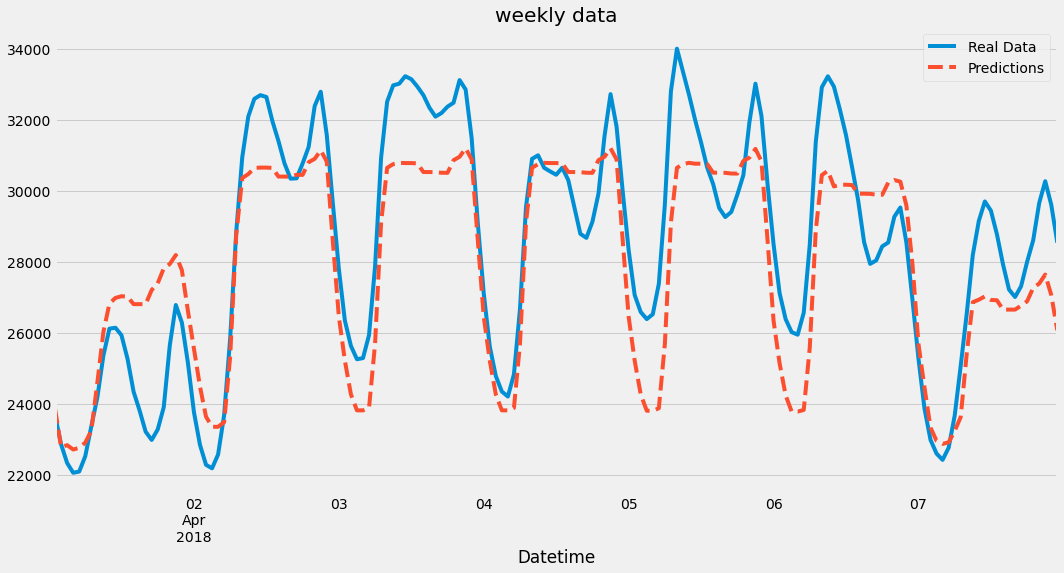

In [21]:
ax=df.loc[(df.index>'04-01-2018')&(df.index<'04-08-2018')]['PJME_MW'].plot(figsize=(16,8),title='weekly data')
df.loc[(df.index>'04-01-2018')&(df.index<'04-08-2018')]['prediction'].plot(style='--')
plt.legend(['Real Data','Predictions'])
plt.show()


In [22]:
score=np.sqrt(mean_squared_error(test['PJME_MW'],test['prediction']))
score

3714.530191611067

# calculate the error

best and worst prediction day

In [23]:
test['error']=np.abs(test[Target]-test['prediction'])

In [24]:
test['date']=test.index.date

In [25]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head()

date
2016-08-13    14559.813965
2016-08-14    14393.350911
2016-09-10    12564.790202
2016-08-12    11527.895264
2016-09-09    11432.962240
Name: error, dtype: float64

we see that the worst prediction days in middle of august

In [26]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head()

date
2016-09-27    376.074544
2016-05-01    420.460286
2016-04-04    432.775065
2015-03-10    444.994792
2016-12-08    480.121663
Name: error, dtype: float64

the best prediction days in end of september and first of may and april